# Load MNIST

In [1]:
from kan import *
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import os

device = torch.device('cpu')
print(device)

cpu


In [2]:
train_data = torchvision.datasets.MNIST(root="./data/", train=True, download=True, transform=None)
test_data = torchvision.datasets.MNIST(root="./data/", train=False, download=True, transform=None)

def preprocess_data(data):
    images = []
    labels = []
    for img, label in data:
        img = np.array(img)
        img = img.flatten() / 255.0
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = preprocess_data(train_data)
test_images, test_labels = preprocess_data(test_data)

dataset = {
    "train_input": torch.from_numpy(train_images).float().to(device),
    "train_label": torch.from_numpy(train_labels).long().to(device),
    "test_input": torch.from_numpy(test_images).float().to(device),
    "test_label": torch.from_numpy(test_labels).long().to(device),
}

# Train Tiny KAN Model

In [3]:
def create_kan():
    return KAN(width=[784,256,256,256,10], grid=4, k=2).to(device)
    
model = create_kan()
print(model)

checkpoint directory created: ./model
saving model version 0.0
MultKAN(
  (act_fun): ModuleList(
    (0-3): 4 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-3): 4 x Symbolic_KANLayer()
  )
)


In [4]:
def test_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["test_input"]), dim=1)
        correct = (predictions == dataset["test_label"]).float()
        accuracy = correct.mean()
    return accuracy

def train_acc():
    with torch.no_grad():
        predictions = torch.argmax(model(dataset["train_input"].to(device)), dim=1)
        correct = (predictions == dataset["train_label"].to(device)).float()
        accuracy = correct.mean()
    return accuracy

# Train the model
results = model.fit(
    dataset,
    opt="LBFGS",
    steps=100,
    batch=512,
    loss_fn=torch.nn.CrossEntropyLoss(),
    metrics=(train_acc, test_acc)
)


 train_loss: 2.24e-02 | test_loss: 5.47e-01 | reg: 5.98e+03 | : 100%|█| 100/100 [1:53:27<00:00, 68.

saving model version 0.1


In [5]:
torch.save(model.state_dict(), "kan_mnist_t.pth")

checkpoint directory created: ./model
saving model version 0.0
Test accuracy: 95.98%
total number of parameters: 4697784


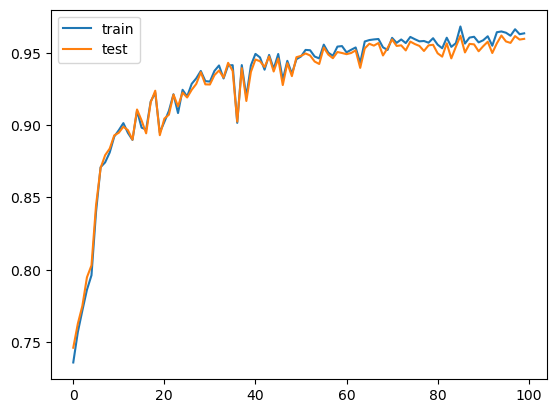

In [6]:
del model
model = create_kan()
model.load_state_dict(torch.load("kan_mnist_t.pth"))

acc = test_acc()
print(f"Test accuracy: {acc.item() * 100:.2f}%")
total_params = sum(p.numel() for p in model.parameters())
print(f"total number of parameters: {total_params}")

plt.plot(results["train_acc"], label="train")
plt.plot(results["test_acc"], label="test")
plt.legend()